In [1]:
import numpy as np
import pandas as pd

In [2]:
# Load NLP modules
import re
import sys
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.util import ngrams

In [3]:
df_business = pd.read_csv('../../data/dataset/csv/business.csv', index_col = 'business_id')
#df_checkin = pd.read_csv('../../data/dataset/csv/checkin.csv', index_col = 'business_id')
#df_photos = pd.read_csv('../../data/dataset/csv/photos.csv', index_col = 'photo_id')
df_review = pd.read_csv('../../data/dataset/csv/review.csv', index_col = 'review_id')
#df_tip = pd.read_csv('../../data/dataset/csv/tip.csv') # index not set for the df_tip
df_user = pd.read_csv('../../data/dataset/csv/user.csv', index_col = 'user_id')

In [4]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
import sklearn.utils

class PreProcessing:
    pd.options.mode.chained_assignment = None  # default='warn'
    # The constructor takes a pandas dataframe as input and save it to self.df
    def __init__(self, df_r, df_b, df_u):
        self.df_r = df_r
        self.df_b = df_b
        self.df_u = df_u
        self.token_pattern = "[a-zA-Z0-9'`]+"


    def TextPreProcessing(self, line):
        ## tokenize
        tokenizer = RegexpTokenizer(self.token_pattern)
        tokens = tokenizer.tokenize( str(line).lower() )
        return tokens

    def Myngrams(self, text, nfold):
        s = []
        for ngram in ngrams(text, nfold):
            s.append(' '.join(str(i) for i in ngram))

        #s = list(set(s)) # unique string in the list
        return s

    def TryDivide(self, x, y, val=0.0):
        """ 
        Try to divide two numbers
        """
        if y != 0.0:
            val = float(x) / y
        return val

    def GetPositionList(self, tgt, obs):
        """
        Get the list of positions of obs in target
        """
        pos_of_obs_in_tgt = [0]
        if len(obs) != 0:
            pos_of_obs_in_tgt = [j for j,w in enumerate(obs, start=1) if w in tgt]
            if len(pos_of_obs_in_tgt) == 0:
                pos_of_obs_in_tgt = [0]
        #print(pos_of_obs_in_tgt)
        return pos_of_obs_in_tgt

    def DumpTextBasicNgram(self, df):
        ## 1-gram
        print("Generate 1-gram...")
        df["text_1gram"] = list(df.apply(lambda x: self.Myngrams(self.TextPreProcessing(x["text"]), 1), axis=1))
        ## 2-gram
        print("Generate 2-gram...")
        df["text_2gram"] = list(df.apply(lambda x: self.Myngrams(self.TextPreProcessing(x["text"]), 2), axis=1))
        ## 3-gram
        print("Generate 3-gram...")
        df["text_3gram"] = list(df.apply(lambda x: self.Myngrams(self.TextPreProcessing(x["text"]), 3), axis=1))
        return df

    def DumpTextCountFeatures(self, df):
        ################################
        ## text count and digit count ##
        ################################
        print("Generate basic text count features...")
        fnames = ["text"]
        ngrams = ["1gram", "2gram", "3gram"]
        CountDigit = lambda x: sum([1. for w in x if w.isdigit()])
    
        for fname in fnames:
            for ngram in ngrams:
                ## word count
                df["Count_%s_%s"%(fname, ngram)] = list(df.apply(lambda x: len(x[fname + "_" + ngram]), axis=1))
                df["CountUnique_%s_%s"%(fname, ngram)] = list(df.apply(lambda x: len(set(x[fname + "_" + ngram])), axis=1))
                df["RatioUnique_%s_%s"%(fname, ngram)] = list(df.apply(lambda x: self.TryDivide(x["CountUnique_%s_%s"%(fname, ngram)], x["Count_%s_%s"%(fname, ngram)]), axis=1))
            ## digit count
            df["CountDigit_%s"%fname] = list(df.apply(lambda x: CountDigit(x[fname + "_1gram"]), axis=1))
            df["RatioDigit_%s"%fname] = list(df.apply(lambda x: self.TryDivide(x["CountDigit_%s"%fname], x["Count_%s_1gram"%(fname)]), axis=1))
        '''
        ## description missing indicator
        #df["description_missing"] = list(df.apply(lambda x: int(x["description_unigram"] == ""), axis=1))
        '''

        df.drop(['text_1gram', 'text_2gram', 'text_3gram'], axis=1, inplace=True)
    
        return df    
    
    def GenTrainDataset(self):
        #merge review and bussiness, based on review
        sub_df_b = self.df_b[['state', 'stars', 'review_count']]
        sub_df_b.rename(index=str, columns={"stars": "bstar_ave", "review_count": "breview_count"}, inplace=True)
        df_train_r_comb_b = pd.merge(self.df_r, sub_df_b, how='left', left_on='business_id' , right_index=True)
    
        #merge review and user, based on review
        sub_df_u = self.df_u[['fans', 'review_count', 'friends']]
        sub_df_u.rename(index=str, columns={"review_count": "ureview_count"}, inplace=True)
        sub_df_u['nfriends'] = list(sub_df_u.apply(lambda x: len(x['friends']), axis=1))
        sub_df_u.drop(['friends'], axis=1, inplace=True)
        df_train_r_comb_b_u = pd.merge(df_train_r_comb_b, sub_df_u, how='left', left_on='user_id', right_index=True)

        #build nlp features...
        df_train = self.DumpTextCountFeatures( self.DumpTextBasicNgram(df_train_r_comb_b_u) )
        df_train.drop(['date', 'text', 'business_id', 'user_id', 'state'], axis=1, inplace=True)
        return df_train

sub_df_review = sklearn.utils.shuffle(df_review).iloc[:200000, :]
preprocessing = PreProcessing(sub_df_review, df_business, df_user)
#preprocessing = PreProcessing(df_review, df_business, df_user)
df_train = preprocessing.GenTrainDataset()
print ("done with train set preprocessing!")
print(df_train.shape)
df_train.head()

Generate 1-gram...
Generate 2-gram...


/home/huawei/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: generator 'ngrams' raised StopIteration


Generate 3-gram...
Generate basic text count features...
done with train set preprocessing!
(200000, 20)


,useful,stars,cool,funny,bstar_ave,breview_count,fans,ureview_count,nfriends,Count_text_1gram,CountUnique_text_1gram,RatioUnique_text_1gram,Count_text_2gram,CountUnique_text_2gram,RatioUnique_text_2gram,Count_text_3gram,CountUnique_text_3gram,RatioUnique_text_3gram,CountDigit_text,RatioDigit_text
review_id,,,,,,,,,,,,,,,,,,,,
LpVXDaKKFNcnXa8Pcv83eA,3,5,3,3,4.5,18,0,9,182,184,113,0.614130,183,175,0.956284,182,182,1.000000,1.0,0.005435
rWZJPu0w_aCJSEjgUtevgg,4,5,0,0,4.5,301,22,255,3900,78,59,0.756410,77,76,0.987013,76,76,1.000000,0.0,0.000000
wmgjoPpZqUxmgAGLRmecCA,0,4,0,0,4.0,651,12,149,390,77,53,0.688312,76,73,0.960526,75,75,1.000000,1.0,0.012987
mOKpiQMegPKHmODxhVGrwA,8,1,1,6,4.0,96,1,19,52,275,155,0.563636,274,257,0.937956,273,272,0.996337,2.0,0.007273
6hnyto3U4iCae1kxTVsrhw,0,5,0,0,2.5,45,0,11,2,107,74,0.691589,106,100,0.943396,105,105,1.000000,0.0,0.000000


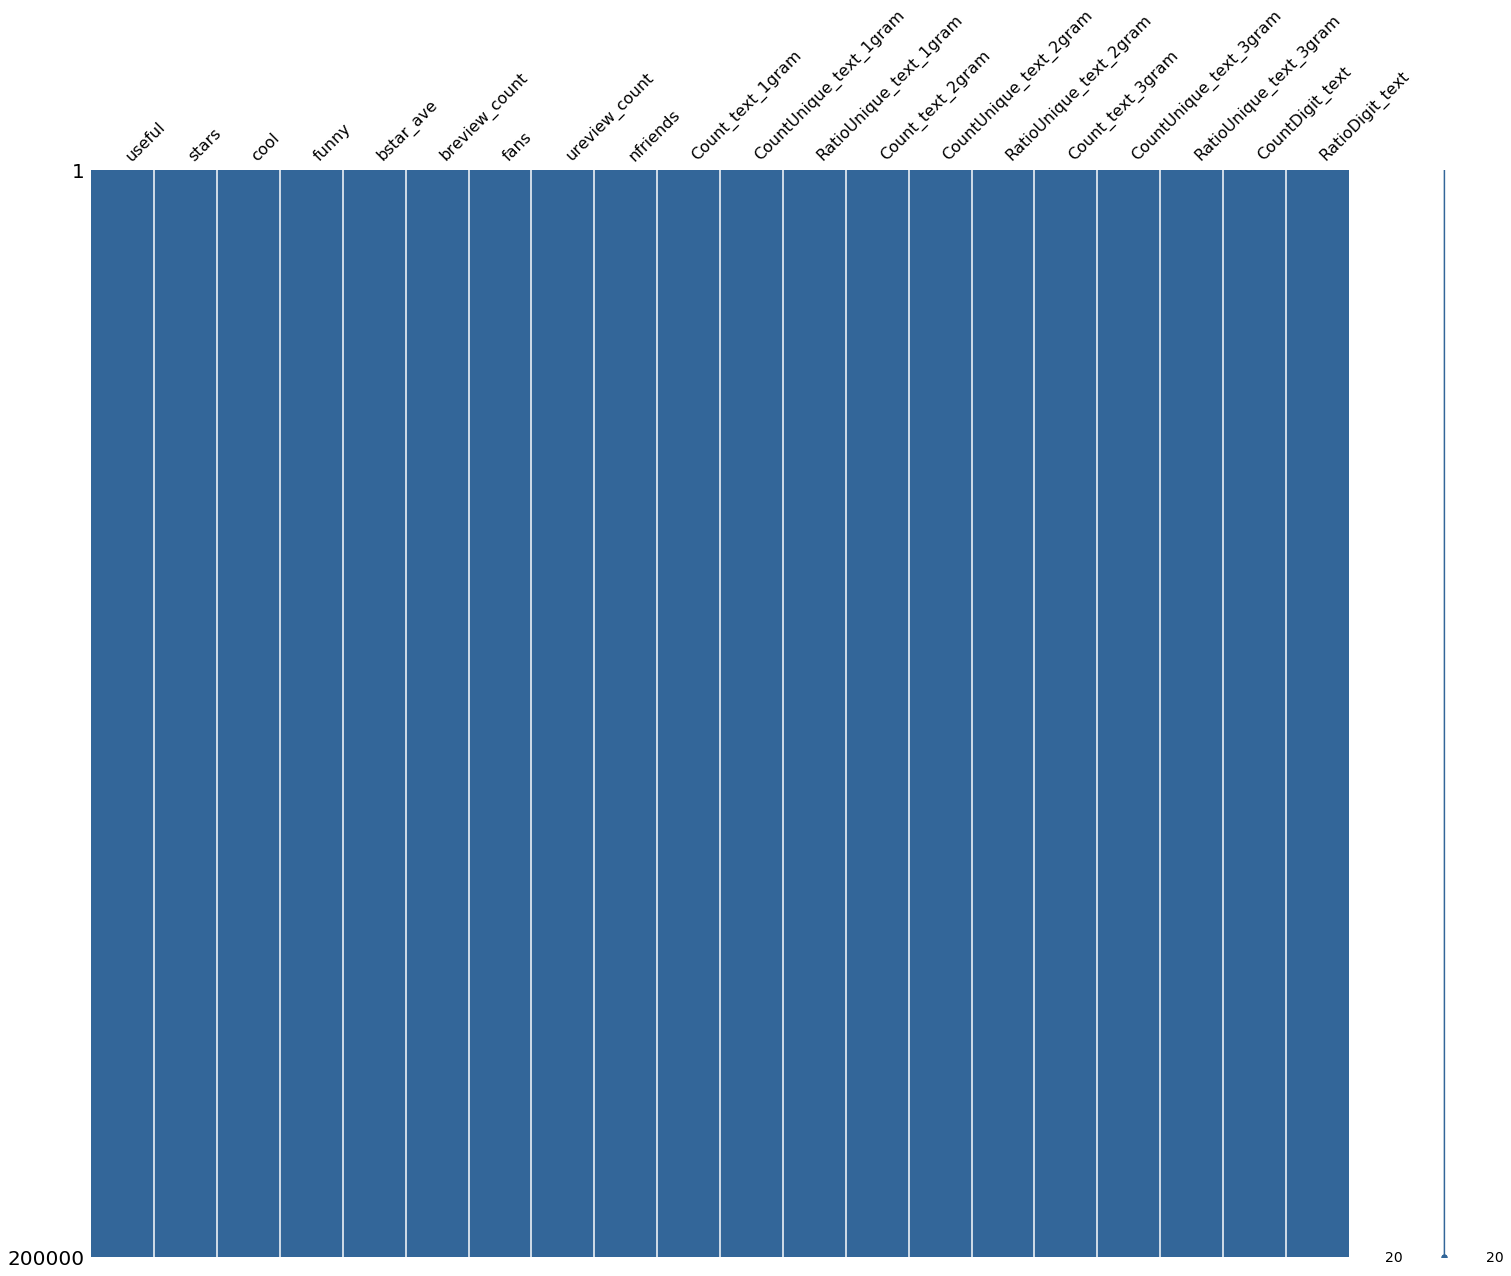

In [5]:
# check missing values...
import missingno as msno
msno.matrix(df=df_train, figsize=(25, 20), color=(0.2, 0.4, 0.6))

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import validation_curve
from sklearn import preprocessing

#df_train.dtypes
X, y = df_train.drop(['stars'],axis=1).values, df_train['stars'].values
myscaler = preprocessing.StandardScaler()
X_scaled = myscaler.fit_transform(X)
#print(X)
#print(y)

# Logistics regression test
#param_range = np.logspace(-2, 3, 6)
#train_scores, test_scores = validation_curve(LogisticRegression(penalty='l2'), X_scaled, y, param_name="C", param_range=param_range, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
#print(np.mean(train_scores, axis=1))
#print(np.std(train_scores, axis=1))
#print(np.mean(test_scores, axis=1))
#print(np.std(test_scores, axis=1))

# Support Vector Regression test
#clf = SVR(C=1.0, epsilon=0.2)
#clf.fit(X, y)
#clf.predict(X)
#param_range = np.logspace(-4, -1, 3)
#train_scores, test_scores = validation_curve(SVR(C=1.0, epsilon=0.2), X_scaled, y, param_name="gamma", param_range=param_range, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
#print(np.mean(train_scores, axis=1))
#print(np.std(train_scores, axis=1))
#print(np.mean(test_scores, axis=1))
#print(np.std(test_scores, axis=1))

# RandomForest
param_range = np.arange(8,13,1)
train_scores, test_scores = validation_curve(RandomForestRegressor(n_estimators=100), X_scaled, y, param_name="max_depth", param_range=param_range, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
#print(np.mean(train_scores, axis=1))
#print(np.std(train_scores, axis=1))
#print(np.mean(test_scores, axis=1))
#print(np.std(test_scores, axis=1))

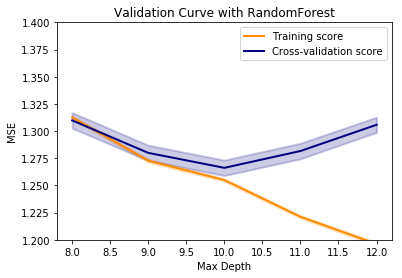

In [32]:
import matplotlib.pyplot as plt
train_score_ave = np.mean(train_scores, axis=1)
train_score_std = np.std(train_scores, axis=1)
cv_score_ave = np.mean(test_scores, axis=1)
cv_score_std = np.std(test_scores, axis=1)
#plt.title("Validation Curve with LogReg")
#plt.title("Validation Curve with SVM")
plt.title("Validation Curve with RandomForest")
#plt.xlabel("C")
#plt.xlabel("$\gamma$")
plt.xlabel("Max Depth")
plt.ylabel("MSE")
plt.ylim(1.2, 1.4)
lw = 2
plt.plot(param_range, -train_score_ave,
             label="Training score", color="darkorange", lw=lw)
plt.fill_between(param_range, -train_score_ave - train_score_std,
                 -train_score_ave + train_score_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, -cv_score_ave, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, -cv_score_ave - cv_score_std,
                 -cv_score_ave + cv_score_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()